In [14]:
#initialisation for easy testing
import Bio
import numpy as np
import sys
import os
import networkx as nx
import random as random
from tqdm import tqdm # loading bar
from utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, get_visiting_order,new_sp_approxi_combi
from utils_copy import convert_to_desired_format_nr_version, compute_cost, my_traversal_simply, extend_alignment_chaos, find_min_span_edges_testing, parse_fasta_multiple_remove_n

score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5

filename='brca1-testseqs.fasta'
filename2='brca1-full.fasta'
brca_seqs_work_please,names=parse_fasta_multiple(filename)
brca_seqs_long=parse_fasta_multiple_remove_n(filename2)

#print(brca_seqs_work_please)
print(brca_seqs_long[0][0:7])

#just testing if the removal of n worked!
sequence=brca_seqs_long[0][7]
contains_n = any(letter.lower() == 'n' for letter in sequence)
if contains_n:
    print("The sequence contains at least one 'n' or 'N'.")
else:
    print("The sequence does not contain 'n' or 'N'.")

brca1_bos_taurus
brca1_canis_lupus
brca1_gallus_gallus
brca1_homo_sapiens
brca1_macaca_mulatta
brca1_mus_musculus
brca1_pan_troglodytes
brca1_rattus_norvegicus
[Seq('atggatttatctgcggatcatgttgaagaagtacaaaatgtcctcaatgctatg...tag'), 'atggatttatctgcggatcatgttgaagaagtacaaaatgtcctcaatgctatgcagaaaatcttagagtgtccaatatgtctggagttgatcaaagagcctgtctctacaaagtgtgaccacatattttgcaaattttgtatgctgaaacttctcaaccagaagaaagggccttcacaatgtcctttgtgtaagaatgatataaccaaaagaagcctacaagaaagtacaagatttagtcaacttgttgaagagctgttgaagatcattcatgcttttgagcttgacacaggattgcagtttgcaaacagctataacttttcgagaaaggaagataactctcctgagcatctgaaggaggaagtttctataatccaaagtatgggctaccggaaccgggccaaaagactttggcagagtgaacctgaaaatcctaccttgcaggaaaccagtcttactgtcgaactctctaaccttggaattgtcagatctctgaggacaaagcagcagacacaatctcagaataagtccgtctacattgaattgggatctgattcttctgaagacacagttaataaggccagttatttcagtgtgggagaccatgaattgttagaaatcacccctcaaggagccaaggccaagaccaatttgaatcctgcagaaaaggctgcttgtgagttttctgagaaggacataacaaatactgaacatcatcaactcagtattaaagatctgatcaccacccagaagcatgcaactgagacgc

In [15]:
def new_sp_approxi_combi(seqs: list[str], score_matrix: dict, gap_cost: int, verbose=False, return_center_string=False,layout="spring",traversal_here="df"):
    # STEP 1: Find the center string, s1
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # loop over all distinct pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
              matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2))
    print(matrix)
    matrix_for_MST=matrix 
    matrix_for_MST=convert_to_desired_format_nr_version(matrix_for_MST)
    min_span_edges=find_min_span_edges_testing(matrix_for_MST)
    print(matrix_for_MST)
    print(min_span_edges)

    max_indices = np.where(matrix == np.max(matrix))
    max_row_index = max_indices[0][0]
    print(max_row_index)

    #need to use the my_transversal_simply to get transversal order but still use get_visiting_order to put edges in the graph!
    visiting_order,G=get_visiting_order(min_span_edges,str(int(max_row_index)),traversal_here,layout) #str(int(np.argmin(matrix.sum(axis = 1)))) to get the min arg as the starting point.
    alignment_pairs,index_dict=my_traversal_simply(G,str(int(max_row_index)))
    print(alignment_pairs)
    print(index_dict)

     # STEP 2: Construct alignment M
    M: list[list[str]] = [[letter] for letter in [*seqs[int(max_row_index)]]]
    print("M right now:")
    print(M)
    print("seqs right now")
    print(seqs)
    cost_list = []
    for key,value in alignment_pairs.items(): #was just seqs bebore
        #you need here to get the pairs from the new dict instead
        cost = linear_C(gap_cost, score_matrix, seqs[int(value)], seqs[int(key)]) #was just seqs before
        print("\n now aligning...."+str(seqs[int(value)])+ " and "+ str(seqs[int(key)]))
        cost_list.append(get_cost_2(cost))
        
        # prepare A-matrix for extension
        alignment1_str, alignment2_str = linear_backtrack(seqs[int(value)], seqs[int(key)], cost, score_matrix, gap_cost)
        str1_nr=value
        alignment1, alignment2 = [*alignment1_str], [*alignment2_str]
        #here you need to provide the nr of the sequences to be able to index in the indexing dict in the extend_alignment_chaos func
        A = [list(e) for e in zip(alignment1,alignment2)]
        print("A right now is: "+str(A))
        print("M right now: "+str(M))
        # extend
        Mk = extend_alignment_chaos(M,str1_nr, A,index_dict) #needs the chaos version
        M = Mk
    
    # ACTUALLY COMPUTE (approximate) COST
    total_cost = compute_cost(M, score_matrix, gap_cost)
    return total_cost, M, matrix_for_MST, visiting_order,G

[[  0.  18. 384. 457.  38. 463.  50. 464.]
 [ 18.   0. 385. 455.  44. 455.  56. 469.]
 [384. 385.   0. 440. 385. 455. 391. 354.]
 [457. 455. 440.   0. 460. 391. 468. 445.]
 [ 38.  44. 385. 460.   0. 451.  16. 471.]
 [463. 455. 455. 391. 451.   0. 452. 459.]
 [ 50.  56. 391. 468.  16. 452.   0. 467.]
 [464. 469. 354. 445. 471. 459. 467.   0.]]
this is E (sorted matrix without any stars yet): 
[['' '16' '4' '6']
 ['' '18' '0' '1']
 ['' '38' '0' '4']
 ['' '44' '1' '4']
 ['' '50' '0' '6']
 ['' '56' '1' '6']
 ['' '354' '2' '7']
 ['' '384' '0' '2']
 ['' '385' '1' '2']
 ['' '385' '2' '4']
 ['' '391' '2' '6']
 ['' '391' '3' '5']
 ['' '440' '2' '3']
 ['' '445' '3' '7']
 ['' '451' '4' '5']
 ['' '452' '5' '6']
 ['' '455' '1' '3']
 ['' '455' '1' '5']
 ['' '455' '2' '5']
 ['' '457' '0' '3']
 ['' '459' '5' '7']
 ['' '460' '3' '4']
 ['' '463' '0' '5']
 ['' '464' '0' '7']
 ['' '467' '6' '7']
 ['' '468' '3' '6']
 ['' '469' '1' '7']
 ['' '471' '4' '7']]

 
 this is it 1
before anything happens: tree1_id

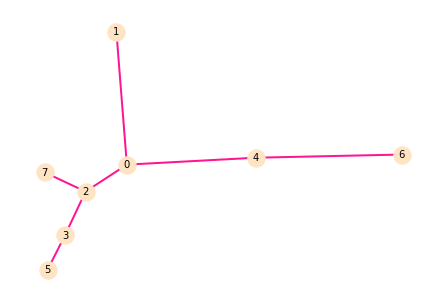

My traversal is df
Neighbors of node 0: ['1', '4', '2']
Neighbors of node 1: ['0']
Neighbors of node 2: ['7', '0', '3']
Neighbors of node 3: ['5', '2']
Neighbors of node 4: ['6', '0']
Neighbors of node 5: ['3']
Neighbors of node 6: ['4']
Neighbors of node 7: ['2']
{'6': '4', '0': '4', '1': '0', '2': '0', '7': '2', '3': '2', '5': '3'}
{'6': '4', '0': '4', '1': '0', '2': '0', '7': '2', '3': '2', '5': '3'}
{'4': '0', '6': '1', '0': '2', '1': '3', '2': '4', '7': '5', '3': '6', '5': '7'}
M right now:
[['a'], ['t'], ['g'], ['g'], ['a'], ['t'], ['t'], ['t'], ['a'], ['t'], ['c'], ['t'], ['g'], ['c'], ['t'], ['g'], ['t'], ['t'], ['c'], ['g'], ['c'], ['g'], ['t'], ['t'], ['g'], ['a'], ['a'], ['g'], ['a'], ['a'], ['g'], ['t'], ['a'], ['c'], ['a'], ['a'], ['a'], ['a'], ['t'], ['g'], ['t'], ['c'], ['a'], ['t'], ['t'], ['a'], ['a'], ['t'], ['g'], ['c'], ['t'], ['a'], ['t'], ['g'], ['c'], ['a'], ['g'], ['a'], ['a'], ['a'], ['a'], ['t'], ['c'], ['t'], ['t'], ['a'], ['g'], ['a'], ['g'], ['t'], ['g'], [

(19348,
 [['-', '-', '-', '-', '-', 'c', '-', '-'],
  ['a', 'a', 'a', 'a', 'g', 'g', 'g', 'g'],
  ['t', 't', 't', 't', 'c', 'c', 't', 't'],
  ['g', 'g', 'g', 'g', 'g', '-', '-', '-'],
  ['g', 'g', 'g', 'g', 'a', 't', 'a', '-'],
  ['a', 'a', 'a', 'a', 'a', 'g', 'c', 't'],
  ['t', 't', 't', 't', '-', '-', '-', '-'],
  ['t', 't', 't', 't', '-', '-', '-', '-'],
  ['t', 't', 't', 't', '-', '-', '-', '-'],
  ['a', 'a', 'a', 'a', 'a', 'g', 'c', 'c'],
  ['t', 't', 't', 't', '-', '-', '-', '-'],
  ['c', 'c', 'c', 'c', '-', '-', '-', '-'],
  ['t', 't', 't', 't', 't', 't', 't', '-'],
  ['g', 'g', 'g', 'g', 'g', 'g', '-', '-'],
  ['c', 'c', 'c', 'c', 't', 'c', 't', 'c'],
  ['t', 't', 'g', 'g', '-', '-', '-', '-'],
  ['g', 'c', 'g', 'g', 'a', 'a', 'g', 'g'],
  ['t', 't', 'a', 'a', 'a', 'a', 'a', 'a'],
  ['t', 't', 't', 't', '-', '-', '-', '-'],
  ['c', 'c', 'c', 'c', 'c', 'c', 't', '-'],
  ['g', 'g', 'a', 'g', 'a', 't', 't', '-'],
  ['c', 'c', 't', 't', 'c', 'c', 't', '-'],
  ['g', 'g', 'g', 'g', '

In [16]:
#running it!! (not ruining it hopefully :P )

new_sp_approxi_combi(brca_seqs_work_please,score_matrix,gap_cost)